In [20]:
from langchain_cohere import CohereEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from datasets import load_dataset


In [21]:
dataset = load_dataset("CShorten/ML-ArXiv-Papers", split="train[:300]")

documents = [
    Document(page_content=f"{paper['title']} - {paper['abstract']}")
    for paper in dataset
]

print(f"Loaded {len(documents)} AI research papers.")


Loaded 300 AI research papers.


In [22]:
COHERE_API_KEY = ""

embedding = CohereEmbeddings(
    model="embed-english-v3.0",
    cohere_api_key=COHERE_API_KEY
)


In [23]:
vectorstore = FAISS.from_documents(documents, embedding)
print("FAISS vectorstore built successfully!")


FAISS vectorstore built successfully!


In [25]:
query = "Recent advancements in multimodal learning using transformers"

retrieved_docs = vectorstore.similarity_search(query, k=10)

print(f"Retrieved {len(retrieved_docs)} documents for reranking.\n")

for i, d in enumerate(retrieved_docs[:3]):
    print(f"{i+1}. {d.page_content[:250]}...\n")


Retrieved 10 documents for reranking.

1. Learning Isometric Separation Maps -   Maximum Variance Unfolding (MVU) and its variants have been very successful
in embedding data-manifolds in lower dimensional spaces, often revealing the
true intrinsic dimension. In this paper we show how to als...

2. Multi-Instance Multi-Label Learning -   In this paper, we propose the MIML (Multi-Instance Multi-Label learning)
framework where an example is described by multiple instances and associated
with multiple class labels. Compared to traditional learning...

3. On-line Learning of an Unlearnable True Teacher through Mobile Ensemble
  Teachers -   On-line learning of a hierarchical learning model is studied by a method from
statistical mechanics. In our model a student of a simple perceptron learns
from not ...



In [26]:
!pip install -qU langchain-cohere


In [27]:
from langchain_cohere import CohereRerank

reranker = CohereRerank(
    model="rerank-english-v3.0",
    cohere_api_key=COHERE_API_KEY
)

texts = [doc.page_content for doc in retrieved_docs]

reranked = reranker.rerank(query=query, documents=texts)

print("\nTop 5 Reranked Results:")
for i, item in enumerate(reranked[:5]):
    idx = item["index"]
    score = item["relevance_score"]
    print(f"\nRank {i+1} | Score: {score:.4f}")
    print(texts[idx][:250], "...")



Top 5 Reranked Results:

Rank 1 | Score: 0.0001
Multi-Instance Multi-Label Learning -   In this paper, we propose the MIML (Multi-Instance Multi-Label learning)
framework where an example is described by multiple instances and associated
with multiple class labels. Compared to traditional learning ...

Rank 2 | Score: 0.0000
Induction of High-level Behaviors from Problem-solving Traces using
  Machine Learning Tools -   This paper applies machine learning techniques to student modeling. It
presents a method for discovering high-level student behaviors from a very
large s ...

Rank 3 | Score: 0.0000
Transfer Learning Using Feature Selection -   We present three related ways of using Transfer Learning to improve feature
selection. The three methods address different problems, and hence share
different kinds of information between tasks or feature ...


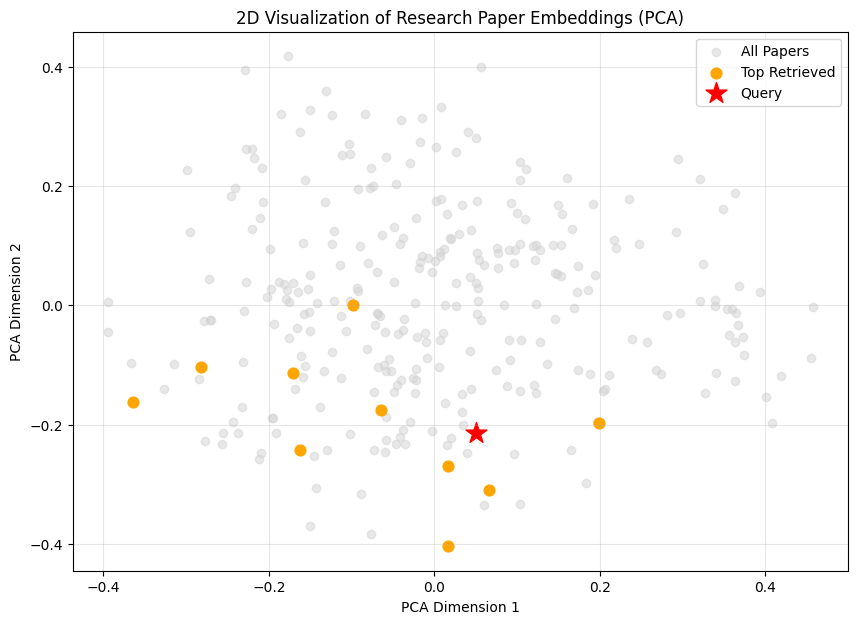

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- Extract embeddings directly from FAISS (no extra API calls) ---
doc_embeddings = np.array(vectorstore.index.reconstruct_n(0, len(documents)))
query_emb = np.array(embedding.embed_query(query))

# --- PCA reduction for visualization ---
pca = PCA(n_components=2)
reduced_docs = pca.fit_transform(doc_embeddings)
reduced_query = pca.transform(query_emb.reshape(1, -1))

# --- Match retrieved documents to embeddings safely ---
retrieved_texts = [d.page_content for d in retrieved_docs]
retrieved_idx = [i for i, d in enumerate(documents) if d.page_content in retrieved_texts]
retrieved_points = reduced_docs[retrieved_idx]

# --- Plot visualization ---
plt.figure(figsize=(10, 7))
plt.scatter(reduced_docs[:, 0], reduced_docs[:, 1], color='lightgray', alpha=0.5, label="All Papers")
plt.scatter(retrieved_points[:, 0], retrieved_points[:, 1], color='orange', s=60, label="Top Retrieved")
plt.scatter(reduced_query[:, 0], reduced_query[:, 1], color='red', marker='*', s=250, label="Query")

plt.title("2D Visualization of Research Paper Embeddings (PCA)")
plt.legend()
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(alpha=0.3)
plt.show()
